In [124]:
import numpy as np
from scipy.sparse import linalg
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from scipy.linalg import qr
from mpl_toolkits.mplot3d import Axes3D 


plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size': 18})

In [125]:
# spatial discretization
L = 40 
n = 256
x2 = np.linspace(-L/2,L/2,n+1)
x = x2[:n]

# wavenumbers for FFT
k = n*(2*np.pi/L)*np.fft.fftfreq(n) # k-vector

# time domain collection points
t = np.linspace(0,2*np.pi,61)


In [126]:
def ch_pod_sol_rhs(ut_split,t,k=k):
    ut = ut_split[:n] + (1j)*ut_split[n:]
    u = np.fft.ifft(ut)
    rhs = -0.5*(1j)*np.power(k,2)*ut + (1j)*np.fft.fft(np.power(np.abs(u),2)*u)
    rhs_split = np.concatenate((np.real(rhs),np.imag(rhs)))
    return rhs_split

In [127]:
N = 2
u0 = N/np.cosh(x)
ut = np.fft.fft(u0)

ut_split = np.concatenate((np.real(ut),np.imag(ut))) # Separate real/complex pieces

utsol_split = integrate.odeint(ch_pod_sol_rhs,ut_split,t,mxstep=10**6)
utsol = utsol_split[:,:n] + (1j)*utsol_split[:,n:]

usol = np.zeros_like(utsol)
for jj in range(len(t)):
    usol[jj,:] = np.fft.ifft(utsol[jj,:]) # transforming back
    

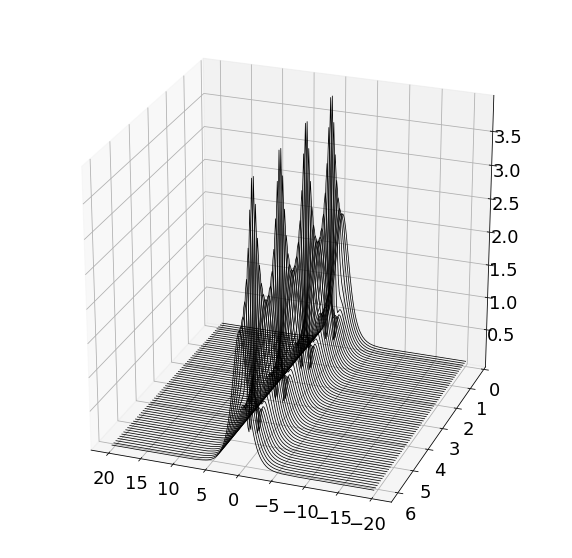

In [128]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.view_init(elev=25, azim=110)

for tt in range(len(t)):
    ax.plot(x,t[tt]*np.ones_like(x),np.abs(usol[tt,:]),color='k',linewidth=0.75)

ax.set_ylim(0,2*np.pi)
plt.show()

In [129]:
X = usol.T # data matrix X
U,S,WT = np.linalg.svd(X,full_matrices=0) # SVD reduction

r = 3 # select rank truncation
Psi = U[:,:r] # select POD modes
a0 = Psi.T @ u0 # project initial conditions

In [130]:
NL = (1j)*np.power(np.abs(X),2)*X
XI,S_NL,WT = np.linalg.svd(NL,full_matrices=0)

# First DEIM point
nmax = np.argmax(np.abs(XI[:,0]))
XI_m = XI[:,0].reshape(n,1)
z = np.zeros((n,1))
P = np.copy(z)
P[nmax] = 1

# DEIM points 2 to r
for jj in range(1,r):
    c = np.linalg.solve(P.T @ XI_m, P.T @ XI[:,jj].reshape(n,1))
    res = XI[:,jj].reshape(n,1) - XI_m @ c
    nmax = np.argmax(np.abs(res))
    XI_m = np.concatenate((XI_m,XI[:,jj].reshape(n,1)),axis=1)
    P = np.concatenate((P,z),axis=1)
    P[nmax,jj] = 1

In [131]:
P_NL = Psi.T @ (XI_m @ np.linalg.inv(P.T @ XI_m)) # nonlinear projection
P_Psi = P.T @ Psi # interpolation of Psi

Lxx = np.zeros((n,r),dtype='complex_')
for jj in range(r):
    Lxx[:,jj] = np.fft.ifft(-np.power(k,2)*np.fft.fft(Psi[:,jj]))

L = 0.5 * (1j) * Psi.T @ Lxx # projected linear term

In [132]:
def rom_deim_rhs(a_split,tspan,P_NL=P_NL,P_Psi=P_Psi,L=L):
    a = a_split[:r] + (1j)*a_split[r:]
    N = P_Psi @ a
    rhs = L @ a + (1j) * P_NL @ (np.power(np.abs(N),2)*N)
    rhs_split = np.concatenate((np.real(rhs),np.imag(rhs)))
    return rhs_split

In [133]:
a0_split = np.concatenate((np.real(a0),np.imag(a0))) # Separate real/complex pieces

a_split = integrate.odeint(rom_deim_rhs,a0_split,t,mxstep=10**6)
a = a_split[:,:r] + (1j)*a_split[:,r:]

Xtilde = Psi @ a.T # DEIM approximation

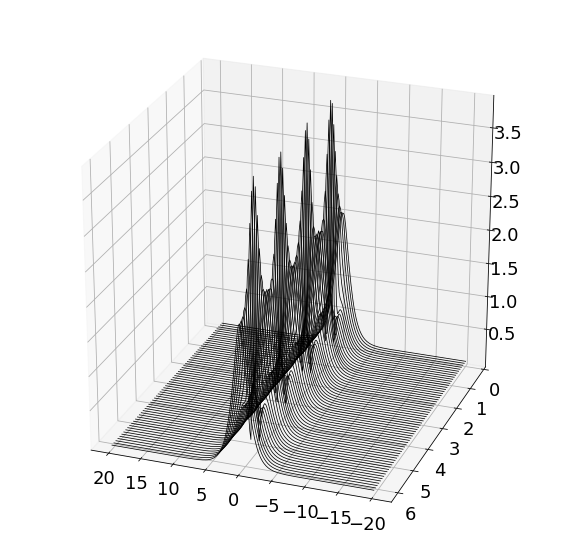

In [134]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.view_init(elev=25, azim=110)

for tt in range(len(t)):
    ax.plot(x,t[tt]*np.ones_like(x),np.abs(Xtilde[:,tt]),color='k',linewidth=0.75)

ax.set_ylim(0,2*np.pi)
plt.show()

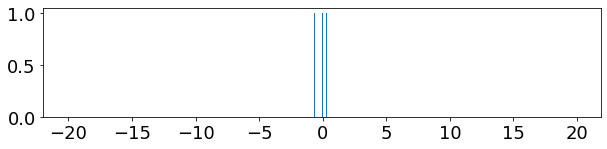

In [135]:
## QR DEIM
Q,R,pivot = qr(NL.T,pivoting=True)
P_qr = np.zeros_like(x)
P_qr[pivot[:3]] = 1

plt.rcParams['figure.figsize'] = [10,2]
plt.bar(x,P_qr,width=0.05)
plt.show()